In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary libraries.

In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from PIL import Image
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

Unzip the dataset stored in your Google Drive.

In [3]:
!unzip /content/drive/MyDrive/Projects/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive/train/0/9687273L.png  
  inflating: archive/train/0/9689906R.png  
 extracting: archive/train/0/9690910L.png  
 extracting: archive/train/0/9690910R.png  
  inflating: archive/train/0/9691359L.png  
  inflating: archive/train/0/9691359R.png  
  inflating: archive/train/0/9692163L.png  
  inflating: archive/train/0/9692604L.png  
  inflating: archive/train/0/9692604R.png  
  inflating: archive/train/0/9692923R.png  
  inflating: archive/train/0/9693364R.png  
  inflating: archive/train/0/9693599L.png  
  inflating: archive/train/0/9693599R.png  
  inflating: archive/train/0/9694101L.png  
  inflating: archive/train/0/9694101R.png  
  inflating: archive/train/0/9695317L.png  
  inflating: archive/train/0/9695317R.png  
  inflating: archive/train/0/9695621L.png  
  inflating: archive/train/0/9695881L.png  
  inflating: archive/train/0/9695881R.png  
  inflating: archive/train/0/9695948L.png  
  inflating: archive/trai

Define paths for training, testing, and validation datasets.

list_of_classes contains the class labels for the dataset.

In [4]:
train_path = '/content/archive/train'
test_path = '/content/archive/test'
valid_path = '/content/archive/val'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

We have three datasets for training,testing and validation. Finding length of each dataset.Organizing the file paths and labels into DataFrames, enabling efficient data loading and preprocessing for training and evaluation.

train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     


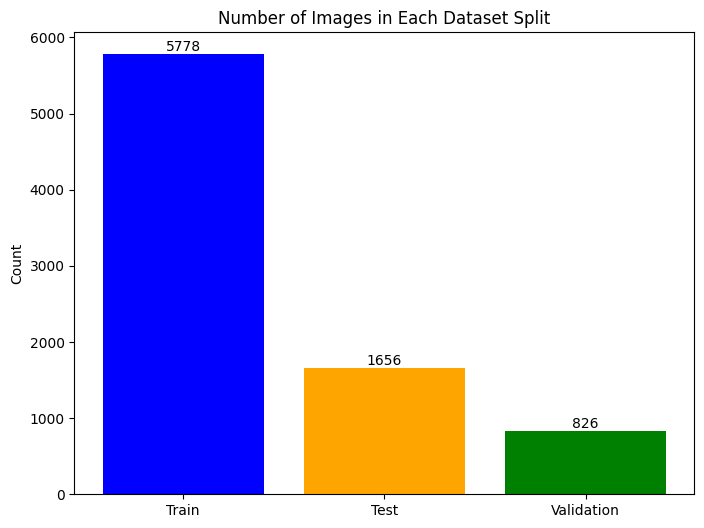

Healthy  has the most images=  2286   Severe  has the least images=  173


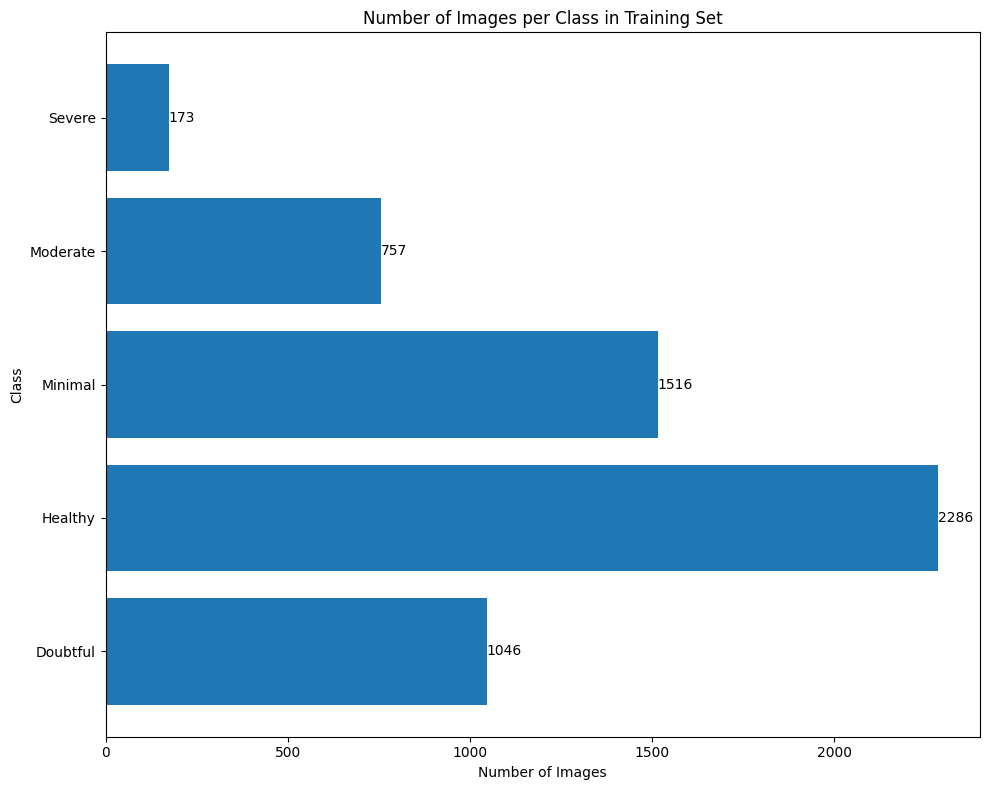

average height=  224  average width=  224 aspect ratio=  1.0


In [5]:
 for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))



# Visualization for dataset splits
plt.figure(figsize=(8, 6))
split_labels = ['Train', 'Test', 'Validation']
split_counts = [len(train_df), len(test_df), len(valid_df)]
plt.bar(split_labels, split_counts, color=['blue', 'orange', 'green'])
plt.title('Number of Images in Each Dataset Split')
plt.ylabel('Count')
for i, count in enumerate(split_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()


# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

# Visualization for class distribution in training set
plt.figure(figsize=(10, 8))
plt.barh(classlist, countlist)
plt.title('Number of Images per Class in Training Set')
plt.xlabel('Number of Images')
plt.ylabel('Class')
for i, count in enumerate(countlist):
    plt.text(count, i, str(count), va='center')
plt.tight_layout()
plt.show()

# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

The first visualisation show the distribution of images in each dataset split.
The second visualisation shows the distribution of images per class in training dataset.

It is found that training, testing, and validation sets, have 5778, 1656, and 826 images respectively.

The dataset is imbalanced, with the Healthy class having the most images (2286) and the Severe class having the fewest (173), which may bias the model toward the majority class.

 The images have an average height and width of 224pixels with an aspect ratio of 1.0, indicating they are square and suitable for deep learning models requiring fixed input sizes.


As we found that the dataset is imbalanced we are reducing it by limiting the number of samples per class to a specified maximum (max_samples) while ensuring no class falls below a minimum threshold (min_samples).

By setting max_samples=500, the function ensures no class exceeds 500 samples, addressing class imbalance and preventing overrepresentation of majority classes like Healthy.

With min_samples=173, the function retains all samples for minority classes (e.g., Severe), ensuring they are not underrepresented in the trimmed dataset.

We are using random sampling (random_state=123) to maintain fairness and reproducibility when reducing class sizes.

Overall, this step of trimming helps create a more balanced dataset, reducing bias and improving the model's ability to generalize across all classes.

In [6]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


**Data Augmentation:** The balance function uses techniques like horizontal flipping, rotation, and zooming to generate synthetic images, increasing dataset diversity and addressing class imbalance.

**Target Class Size:** By setting n=500, the function ensures each class reaches 500 samples, boosting minority classes (e.g., Severe) to match the target size.

**Augmentation Process:** For classes with fewer than 500 samples, the function creates additional images (delta = n - sample_count) and saves them in a dedicated directory (aug_dir).

**Dataset Expansion:** The function merges the original dataset with the augmented images, increasing the total dataset size from 2173 to 2500 samples.

**Improved Model Generalization:** Augmentation enhances the dataset's variability, helping the model generalize better and reducing overfitting to minority or majority classes.

In [7]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
          fpath=os.path.join(classpath,f)
          aug_fpaths.append(fpath)
          aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  2173
Found 173 validated image filenames.
Total Augmented images created=  327
Length of augmented dataframe is now  2500


We are combining the classes Healthy, Doubtful, and Minimal into a single class labeled Healthy, simplifying the classification task and reducing complexity.

After relabeling, the dataset now has three classes: Healthy (1500 samples), Moderate (500 samples), and Severe (500 samples), balancing the dataset for better model training.

Hence, Consolidating classes reduces the number of target categories, making the model easier to train and improving its ability to distinguish between the remaining classes.

In [8]:
def relabel(label_in):
    if label_in =='Healthy' or label_in == 'Doubtful' or label_in =='Minimal':
        label='Healthy'
    else:
        label=label_in
    return label


for df in [train_df, test_df, valid_df]:
    for i in range (len(df)):
        label=df['labels'].iloc[i]
        new_label=relabel(label)
        df['labels'].iloc[i]=new_label
print (train_df['labels'].value_counts())

<ipython-input-8-7d682229a53b>:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['labels'].iloc[i]=new_label


labels
Healthy     1500
Moderate     500
Severe       500
Name: count, dtype: int64


We ensure that each class in the dataset has exactly 500 samples, creating a balanced dataset for training and reducing bias toward any particular class.

By setting both max_samples and min_samples to 500, the function guarantees uniformity across all classes, improving the model's ability to generalize and perform equally well on all categories.

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


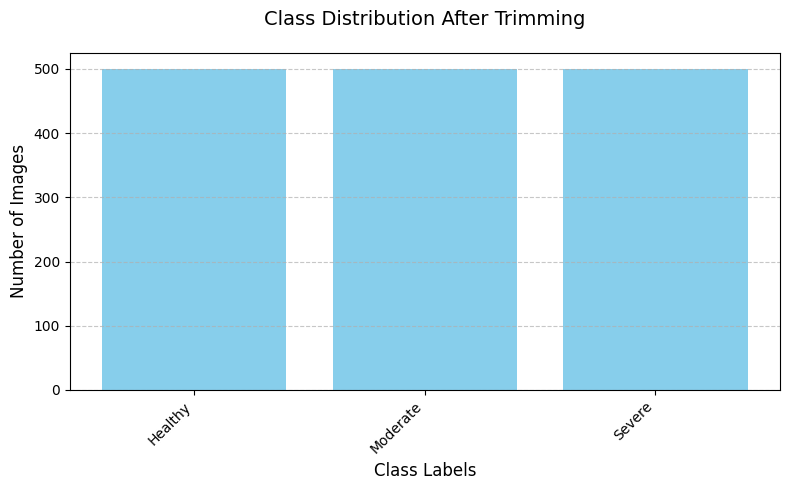

In [9]:
max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

# Get class counts after trimming
class_counts = train_df['labels'].value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title('Class Distribution After Trimming', fontsize=14, pad=20)
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Finding the number of validated images in each datset(training, testing and validation). We should use only the validated images from training and validation datasets.
The visualisation shows that all the classes have same number of images after trimming.


In [10]:
batch_size=20
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1500 validated image filenames belonging to 3 classes.
Found 826 validated image filenames belonging to 3 classes.
Found 1656 validated image filenames belonging to 3 classes.
test batch size:  72   test steps:  23  number of classes :  3


Display sample batch of images from the data generator, along with their corresponding class labels, to provide a visual understanding of the dataset.


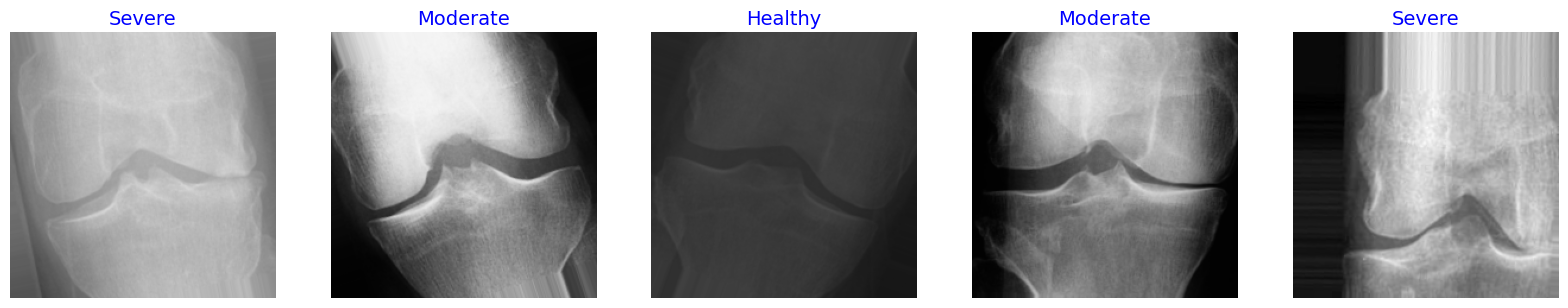

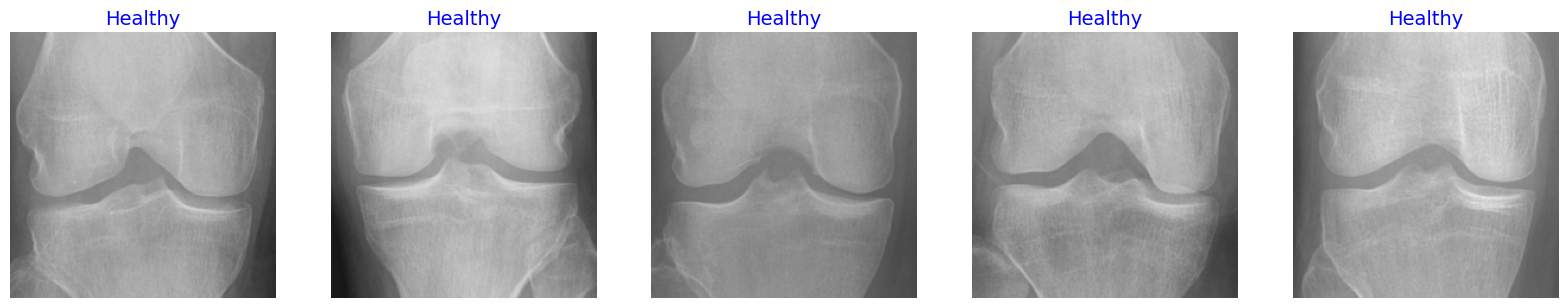

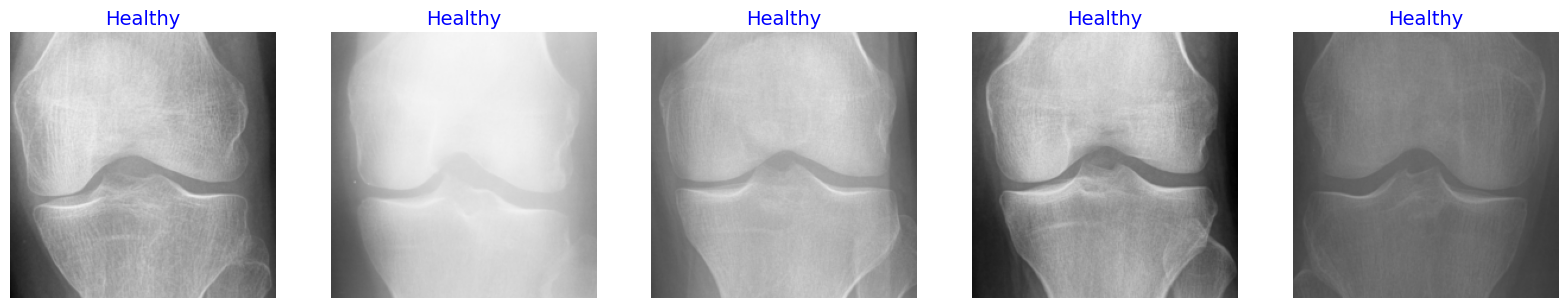

In [11]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<5:   #show maximum of 25 images
        r=length
    else:
        r=5
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )
show_image_samples(test_gen )
show_image_samples(valid_gen )

#Baseline Model

Import necessary libraries

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Baseline CNN Architecture Rationale**

We used a 3-layer CNN for the baseline model to keep it simple and interpretable. This serves as a starting point to evaluate performance before scaling up to more complex architectures. Increasing the number of layers may improve performance by enabling deeper feature extraction but could also increase overfitting or training time, especially with limited data. This tradeoff will be explored in Stage 5 with deeper models like EfficientNetB5.


In [20]:
#Define the Baseline CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes: Healthy, Moderate, Severe
])

**Model Compilation**

We compile the model using the Adam optimizer and categorical crossentropy loss, which is suitable for multi-class classification. Accuracy is used as the evaluation metric to track how well the model is learning over time.

Loss Function - Categorical Crossentropy


In [21]:
#Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Callbacks**

We use two callbacks to improve training:
- **EarlyStopping** monitors validation loss and stops training if it doesn't improve for 5 epochs, helping to avoid overfitting.
- **ReduceLROnPlateau** lowers the learning rate when the model hits a performance plateau, allowing for finer adjustments during training.


In [22]:
#Define Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

**Model Architecture**

This displays the architecture of our CNN, including the number of layers, output shapes, and total parameters. It provides a quick overview of the model's complexity and trainable components.


In [ ]:
model.summary()

**Model Training**

We train the model for up to 20 epochs using the training and validation data. The callbacks help monitor performance and adjust learning dynamically. The `history` object stores accuracy and loss metrics for both training and validation, which we’ll later use to visualize learning progress.


In [23]:
#Train the Model
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=[early_stop, lr_reduction]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 296ms/step - accuracy: 0.4147 - loss: 13.4999 - val_accuracy: 0.0327 - val_loss: 122.9016 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 294ms/step - accuracy: 0.4444 - loss: 2.3209 - val_accuracy: 0.0581 - val_loss: 17.4988 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - accuracy: 0.4915 - loss: 1.5280 - val_accuracy: 0.0678 - val_loss: 15.5795 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - accuracy: 0.5080 - loss: 1.3725 - val_accuracy: 0.0363 - val_loss: 51.5454 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4722 - loss: 1.1362
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 374ms/step - accuracy: 0.4724 - loss: 1.1347 - val_accuracy: 0.0375 - val_loss: 176.7340 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - accuracy: 0.5066 - lo

**Training Summary**

The model initially struggled with high loss and low validation accuracy during the first few epochs, but improved significantly after learning rate adjustments. The `ReduceLROnPlateau` callback helped the model escape local minima, leading to steady performance gains.

By epoch 13–19, both training and validation accuracy stabilized between **~64% and 80%**, and validation loss dropped to around **0.66**, indicating a strong learning phase and good generalization. This shows that our CNN is capable of learning meaningful patterns from the knee X-ray data.


**Model Evaluation on Test Set**

We evaluate the final model on the unseen test dataset to measure its generalization performance. The test accuracy provides an objective measure of how well the model is likely to perform in real-world settings.


In [24]:
#Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.8291 - loss: 0.6583
Test Accuracy: 78.99%


**Final Test Performance**

On the unseen test dataset, the model achieved **78.99% accuracy** with a loss of **0.6583**. This aligns closely with the validation accuracy from training, indicating that the model generalizes well and is not overfitting. These results demonstrate the effectiveness of our baseline CNN and set the stage for further performance gains using more advanced architectures like EfficientNet.


**Training vs Validation Accuracy and Loss**

The following plots show how accuracy and loss changed over the course of training. We can see that validation accuracy closely follows training accuracy, and validation loss decreases steadily after initial fluctuations. This suggests that the model is learning effectively without significant overfitting.


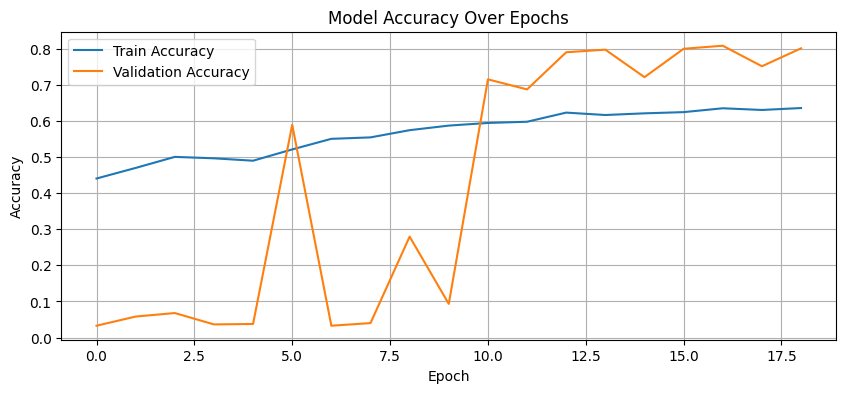

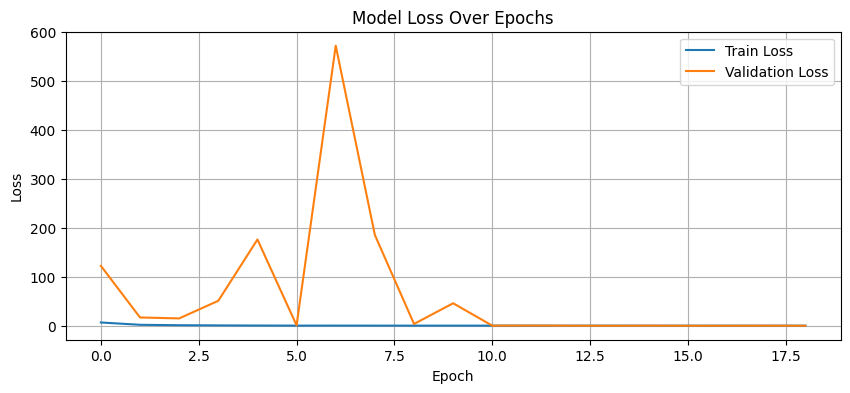

In [25]:
# Accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

**Observations from Training and Validation Curves**

The accuracy plot shows a clear upward trend for both training and validation accuracy, indicating effective learning. While the validation accuracy fluctuates slightly early on, it stabilizes and eventually surpasses the training accuracy — a strong sign of generalization.

The loss plot reveals some instability in validation loss during the initial epochs, likely due to a high learning rate and model adjustments. However, as training progresses and the learning rate is reduced, both losses converge, and validation loss drops sharply to a stable, low value. This confirms the model has learned meaningful features and is not overfitting.


**Confusion Matrix**

The confusion matrix provides a breakdown of how well the model predicted each class — Healthy, Moderate, and Severe. It shows the number of correct and incorrect predictions for each class, helping us identify specific areas where the model might be confusing one class for another. This is especially useful in medical applications where misclassifying severity could have real consequences.


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step
Confusion Matrix


<Axes: >

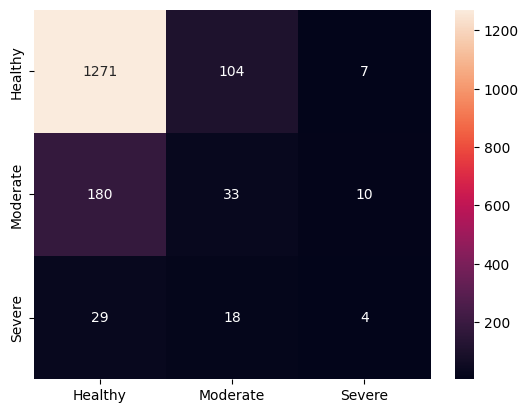

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())

**Confusion Matrix Analysis**

The confusion matrix shows that the model performs very well at identifying **Healthy** cases, with 1271 correct predictions. However, it struggles with **Moderate** and **Severe** cases, often misclassifying them as Healthy.

- **Moderate**: Out of all Moderate cases, many are being predicted as Healthy (180 misclassified).
- **Severe**: Similar pattern — most Severe cases are also predicted as Healthy (29 misclassified).



**Classification Report**

This report provides a more detailed breakdown of the model’s performance for each class using:
- **Precision**: How many of the predicted class labels were actually correct.
- **Recall**: How many of the actual class samples were correctly identified.
- **F1-score**: The harmonic mean of precision and recall — a balanced performance metric.

The report shows that the model performs very well for the **Healthy** class, while struggling with **Moderate** and **Severe**, which is consistent with what we observed in the confusion matrix. This further highlights the need to improve class balance and feature learning for underrepresented or harder-to-distinguish cases.


In [29]:
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.86      0.92      0.89      1382
    Moderate       0.21      0.15      0.17       223
      Severe       0.19      0.08      0.11        51

    accuracy                           0.79      1656
   macro avg       0.42      0.38      0.39      1656
weighted avg       0.75      0.79      0.77      1656



**Interpretation of Classification Report**

The model performs very well on the **Healthy** class, with a precision of **0.86**, recall of **0.92**, and F1-score of **0.89**. However, it struggles to correctly identify the **Moderate** and **Severe** cases:

- **Moderate:** Precision and recall are low (0.21 and 0.15), indicating frequent misclassifications, mostly as Healthy.
- **Severe:** Even lower recall (0.08), suggesting the model often fails to detect severe cases.

The **macro average** (which treats all classes equally) shows an overall F1-score of **0.39**, while the **weighted average** (which accounts for support/class imbalance) is much higher at **0.77**, driven by strong performance on the majority class (Healthy).

## References
**Keras API Documentation** - https://keras.io/api/

**ReduceLROnPlateau (Keras Callback)** - https://keras.io/api/callbacks/reduce_lr_on_plateau/

**EarlyStopping (Keras Callback)** - https://keras.io/api/callbacks/early_stopping/

**BatchNormalization Layer - Keras** - https://keras.io/api/layers/normalization_layers/batch_normalization/

**MaxPooling2D Layer - Keras** - https://keras.io/api/layers/pooling_layers/max_pooling2d/

**Dropout Layer - Keras** - https://keras.io/api/layers/regularization_layers/dropout/

**Dense Layer - Keras** - https://keras.io/api/layers/core_layers/dense/

**Conv2D Layer - Keras** - https://keras.io/api/layers/convolution_layers/convolution2d/

**categorical_crossentropy Loss - Keras** - https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-function
